In [1]:
library(ggplot2)
library(stringr)
library(magrittr)
library(WriteXLS)
library(tidyr)
library(dplyr)
library(plotly)
library(cluster)
library(cowplot)
library(gridExtra)
library(viridis)
library(GenomicRanges)
library(GenomeInfoDb)
library(data.table)
library(ComplexHeatmap)
library(ArchR)
suppressMessages(library(chromVAR))
suppressMessages(library(gchromVAR))
suppressMessages(library(SummarizedExperiment))
suppressMessages(library(data.table))
suppressMessages(library(BiocParallel))
suppressMessages(library(BSgenome.Hsapiens.UCSC.hg38))


Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: viridisLite

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply

In [2]:
# liftover the snps from hg19 to hg38
liftover_tool <- "/home/rs619065/opt/UCSCTools/liftOver"
chain_file <- "/home/rs619065/opt/ChainFiles/hg19ToHg38.over.chain.gz"

lapply(list.files("./CausalSNPs"), function(x){
    x <- tools::file_path_sans_ext(basename(x))
    message(sprintf("processing : %s", x))
    
    df <- read.table(glue::glue("./CausalSNPs/{x}.txt"), header = TRUE) %>%
        subset(., select = c("CHR", "BP", "rsID", "FINEMAP")) %>%
        subset(., FINEMAP > 0.01)
    
    df$BP2 <- df$BP
    df$BP <- df$BP - 1
    df$CHR <- paste0("chr", df$CHR)
    df$rsID <- paste0("rs", df$rsID)
    df <- subset(df, select = c("CHR","BP", "BP2", "rsID", "FINEMAP"))
        
    df <- df[order(df$CHR, df$BP, df$BP2), ]
        
    write.table(df, file = glue::glue("./CausalSNPsBedFile/{x}.bed"),
                    sep = "\t", row.names = FALSE, col.names = FALSE,
                    quote = FALSE)
    
    ## hg19 to hg38
    command <- glue::glue("{liftover_tool} ./CausalSNPsBedFile/{x}.bed {chain_file} ./CausalSNPs_hg38/{x}.bed ./CausalSNPs_hg38/{x}_umapped.bed")

    system(command)
    system(glue::glue("rm ./CausalSNPs_hg38/{x}_umapped.bed"))
})

processing : AF_credible_set_CA249

processing : Albumin_credible_set_OT241

processing : Angina_credible_set_GA365

processing : Asthma_credible_set_AT534

processing : Bilirubin_credible_set_OT253

processing : CAD_credible_set_CA448

processing : CreatinineKinase_credible_set_OT262

processing : CRP_credible_set_CA292

processing : FastingGlucose_credible_set_PH336

processing : HDL_credible_set_PH276

processing : HgA1c_credible_set_OT239

processing : HTN_credible_set_AT286

processing : Hypercholesterolemia_credible_set_AT443

processing : Hypothyroidism_credible_set_AT034

processing : LDL_credible_set_PH278

processing : MS_credible_set_CA021

processing : Osteoperosis_credible_set_AT444

processing : RA_credible_set_CA104

processing : SEL_credible_set_CA022

processing : SerumCreatinine_crediblie_set_OT245

processing : SerumUrate_credible_set_PH295

processing : T2D_credible_set_OT332

processing : TotalCholesterol_credible_set_PH280

processing : Triglycerides_credible_set_

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

[[11]]
[1] 0

[[12]]
[1] 0

[[13]]
[1] 0

[[14]]
[1] 0

[[15]]
[1] 0

[[16]]
[1] 0

[[17]]
[1] 0

[[18]]
[1] 0

[[19]]
[1] 0

[[20]]
[1] 0

[[21]]
[1] 0

[[22]]
[1] 0

[[23]]
[1] 0

[[24]]
[1] 0

[[25]]
[1] 0

In [3]:
set.seed(42)
proj <- loadArchRProject(path = "../ArchR/HFFiltering", showLogo = FALSE)

Successfully loaded ArchRProject!



In [4]:
## get all linked peaks
p2g_control <- readRDS("../ArchR/Control/p2g.Rds")
p2g_hf_a <- readRDS("../ArchR/HF_A/p2g.Rds")
p2g_hf_ckd <- readRDS("../ArchR/HF_CKD/p2g.Rds")

p2g_control$Peak2GeneLinks$KmeansCluster <- p2g_control$ATAC$kmeansId
p2g_hf_a$Peak2GeneLinks$KmeansCluster <- p2g_hf_a$ATAC$kmeansId
p2g_hf_ckd$Peak2GeneLinks$KmeansCluster <- p2g_hf_ckd$ATAC$kmeansId

df_p2g_control <- as.data.frame(p2g_control$Peak2GeneLinks)
df_p2g_hf_a <- as.data.frame(p2g_hf_a$Peak2GeneLinks)
df_p2g_hf_ckd <- as.data.frame(p2g_hf_ckd$Peak2GeneLinks)

p2g <- rbind(df_p2g_control, df_p2g_hf_a, df_p2g_hf_ckd)

idx_ATAC <- unique(p2g$idxATAC)

In [5]:
counts <- readRDS("../ArchR/HFFiltering/PeakMatrix.Rds")
counts <- counts[idx_ATAC, ]

df <- proj@cellColData %>%
   as.data.frame() %>%
   subset(., CellType %in% c("fibroblast", "adipocytes", "cardiomyocyte",
                             "T-cells", "pericyte", "endothelial", "macrophages", "vSMCs"))

df$Condition_CellType <- paste0(df$Condition, "_", df$CellType)

bulkPeakMatrix <- lapply(unique(df$Condition_CellType), function(x){
    cells <- rownames(df)[df$Condition_CellType == x]
    
    bulk <- rowMeans(counts[, cells]) %>%
        as.data.frame()
    
    colnames(bulk) <- x
    
    bulk
    
}) %>% Reduce(cbind, .)


#saveRDS(bulkPeakMatrix, file = "bulkPeakMatrix.Rds")

In [6]:
head(bulkPeakMatrix)

,HF_A_macrophages,HF_A_fibroblast,HF_A_adipocytes,HF_A_cardiomyocyte,HF_A_endothelial,HF_A_vSMCs,HF_A_pericyte,HF_A_T-cells,Control_fibroblast,Control_cardiomyocyte,⋯,Control_T-cells,HF_CKD_fibroblast,HF_CKD_cardiomyocyte,HF_CKD_macrophages,HF_CKD_endothelial,HF_CKD_pericyte,HF_CKD_T-cells,HF_CKD_vSMCs,Control_adipocytes,HF_CKD_adipocytes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1_830674_831174,0.0000000000,0.0004329942,0.032761310,0.05674192,0.0000000000,0.000000000,0.002300173,0.000000000,0.001655629,0.03224688,⋯,0.000000000,0.0000000000,0.02066487,0.0000000000,0.0000000000,0.000000000,0,0.000000000,0.000000000,0.00000000
chr1_831216_831716,0.0012722646,0.0032474562,0.021840874,0.10341672,0.0016920474,0.003174603,0.005175388,0.000000000,0.005794702,0.03987517,⋯,0.006711409,0.0031545741,0.06379155,0.0009945301,0.0027453672,0.001443001,0,0.000000000,0.000000000,0.05882353
chr1_832108_832608,0.0012722646,0.0034639532,0.007800312,0.06802929,0.0008460237,0.007936508,0.001725129,0.004291845,0.001655629,0.06657420,⋯,0.016778523,0.0031545741,0.06469003,0.0019890602,0.0006863418,0.000000000,0,0.000000000,0.009615385,0.00000000
chr1_835443_835943,0.0008481764,0.0004329942,0.037441498,0.08511287,0.0000000000,0.003174603,0.000000000,0.000000000,0.001655629,0.09986130,⋯,0.000000000,0.0007886435,0.07097934,0.0024863252,0.0000000000,0.000000000,0,0.000000000,0.000000000,0.00000000
chr1_858574_859074,0.0016963528,0.0082268889,0.027301092,0.12172056,0.0042301184,0.006349206,0.005175388,0.006437768,0.004966887,0.10367545,⋯,0.020134228,0.0078864353,0.12668464,0.0004972650,0.0041180508,0.004329004,0,0.000000000,0.019230769,0.00000000
chr1_865598_866098,0.0008481764,0.0017319766,0.005460218,0.08968883,0.0025380711,0.009523810,0.001150086,0.002145923,0.004139073,0.08737864,⋯,0.000000000,0.0031545741,0.08176101,0.0000000000,0.0034317090,0.000000000,0,0.006622517,0.000000000,0.00000000


In [7]:
# gchromVAR for enrichment
df <- stringr::str_split_fixed(rownames(bulkPeakMatrix), "_", 3)
peaks <- GRanges(seqnames = df[, 1], ranges = IRanges(start = as.numeric(df[, 2]), 
                                                      end = as.numeric(df[, 3])))

rownames(bulkPeakMatrix) <- NULL

SE <- SummarizedExperiment(assays = list(counts = as.matrix(bulkPeakMatrix)),
                           rowData = peaks, 
                           colData = DataFrame(names = colnames(bulkPeakMatrix)))

SE <- addGCBias(SE,
                genome = BSgenome.Hsapiens.UCSC.hg38)

In [8]:
# enrichment
files <- list.files("./CausalSNPs_hg38",
                    full.names = TRUE, pattern = "*.bed$")

ukbb <- importBedScore(rowRanges(SE), files, colidx = 5)

ukbb_wDEV <- computeWeightedDeviations(SE, ukbb)
z <- t(assays(ukbb_wDEV)[["z"]])

## remove NA
z <- z[ , colSums(is.na(z)) == 0]
colnames(z) <- stringr::str_split_fixed(colnames(z), "_", 4)[, 1]

png 
  2

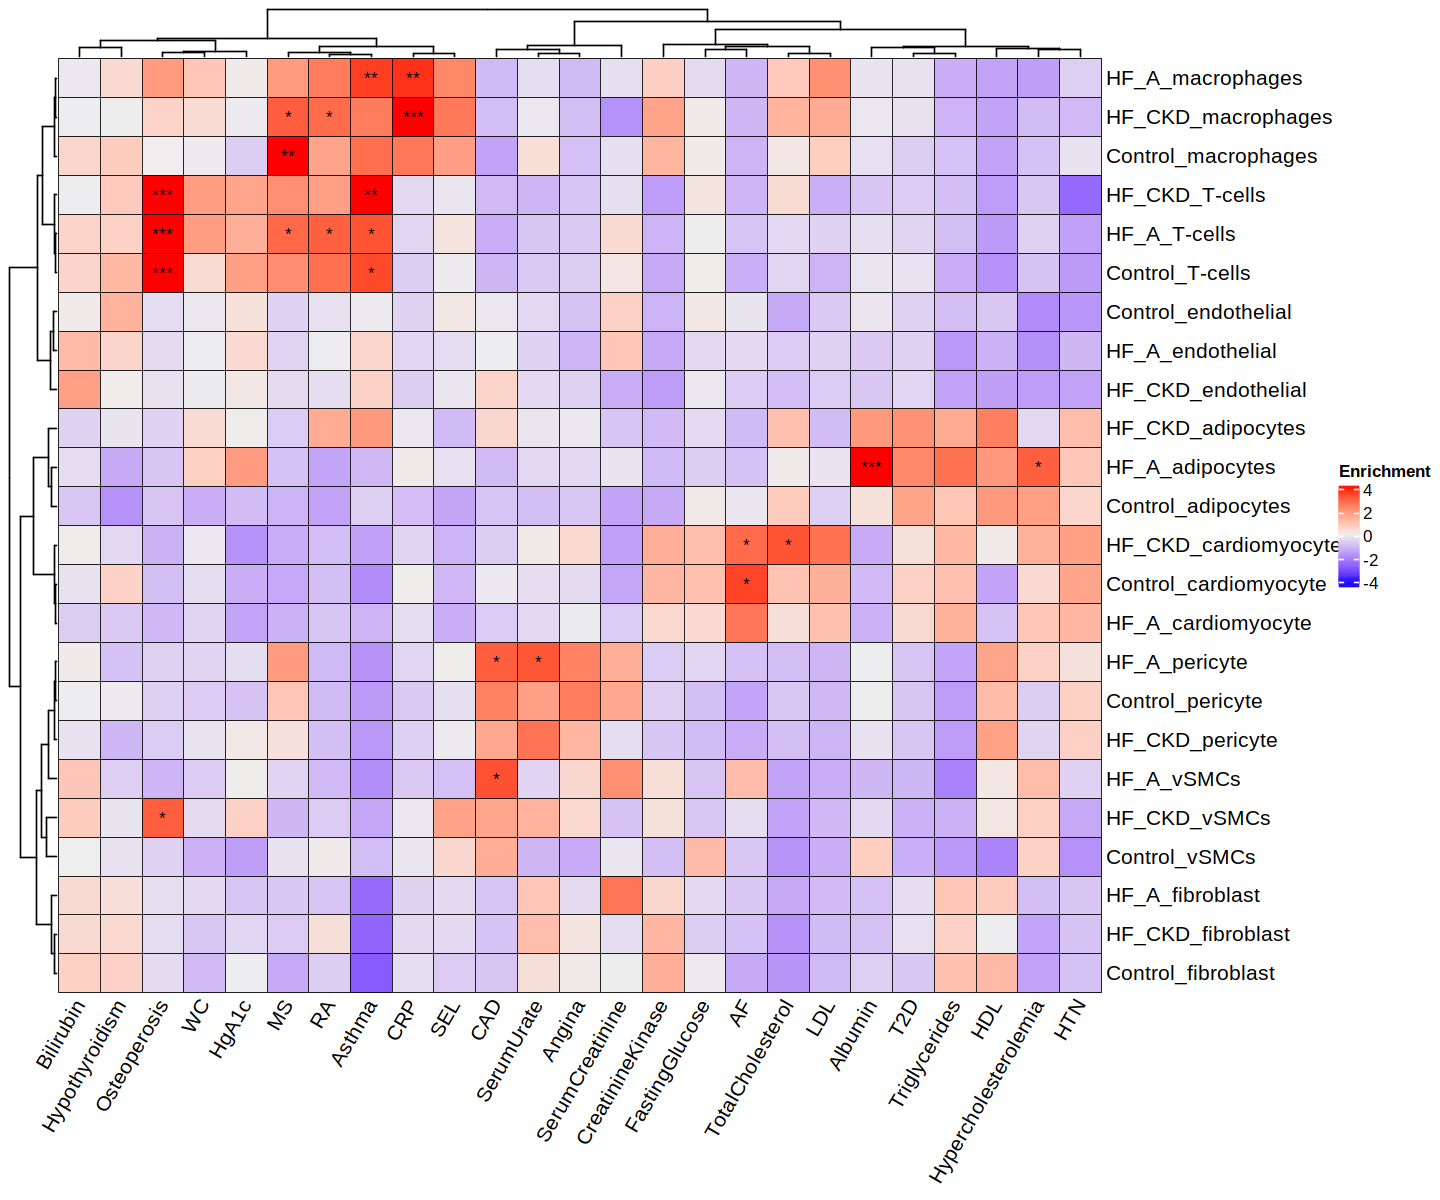

In [9]:
Diseases <- c("AF", "Angina", "CAD", "HTN", 
              "Hypothyroidism", "Hypercholesterolemia", "T2D", "Osteoperosis",
              "MS", "RA", "Asthma", "SEL")

Traits <- c("Albumin", "Bilirubin", "CRP", "SerumCreatinine",
            "CreatinineKinase", "SerumUrate", "FastingGlucose", "HgA1c", 
            "LDL", "HDL", "Triglycerides", "TotalCholesterol",
            "WC")

df_anno <- data.frame(Phenotype = c(Diseases, Traits),
                      Anno = c(rep("Disease", length(Diseases)),
                               rep("Traits", length(Traits))))
rownames(df_anno) <- df_anno$Phenotype
df_anno$Phenotype <- NULL

column_ha <- HeatmapAnnotation(df = df_anno,
                               col = list(Anno = c("Disease" = "#a6cee3",
                              "Traits" = "#1f78b4")))
z <- z[, rownames(df_anno)]

pvalue <- pnorm(z, lower.tail = FALSE)
pvalue <- p.adjust(pvalue, method = "BH")
pvalue <- matrix(pvalue, ncol = ncol(z)) 

rownames(pvalue) <- rownames(z)
colnames(pvalue) <- colnames(z)

cn <- colnames(z)

p <- Heatmap(z, name = "Enrichment",
             clustering_distance_columns = "pearson",
             clustering_distance_rows = "pearson",
             clustering_method_rows = "ward.D2",
             clustering_method_columns = "ward.D2",
             show_column_names = FALSE,
             rect_gp = gpar(col = "black", lwd = 0.5, lty = "solid"),
             bottom_annotation = HeatmapAnnotation(
                 text = anno_text(cn, rot = 60, 
                                  location = unit(1, "npc"), just = "right"),
                 annotation_height = max_text_width(cn)),
             cell_fun = function(j, i, x, y, width, height, fill) {
                 if (pvalue[i, j] < 0.001){
                     grid.text("***", x, y, gp = gpar(fontsize = 10))
                 }
                else if(pvalue[i, j] < 0.01 & pvalue[i, j] > 0.001){
                            grid.text("**", 
                  x, y, gp = gpar(fontsize = 10))
                } else if(pvalue[i, j] > 0.01 & pvalue[i, j] < 0.05){
                     grid.text("*", 
                  x, y, gp = gpar(fontsize = 10))
                }
})

options(repr.plot.height = 10, repr.plot.width = 12) 
                 
p
    
pdf("./Plots/gwas_enrichment_with_average_signal.pdf", height = 10, width = 12)
                 draw(p)
                 dev.off()

In [10]:
saveRDS(z, "./Enrichment/z_score.Rds")
saveRDS(pvalue, "./Enrichment/p_value.Rds")

In [11]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 8

Matrix products: default
BLAS/LAPACK: /home/rs619065/miniconda3/envs/r-4.0.3/lib/libopenblasp-r0.3.12.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] BSgenome.Hsapiens.UCSC.hg38_1.4.3 BSgenome_1.58.0                  
 [3] rtracklayer_1.50.0                Biostrings_2.58.0                
 [5] XVector_0.30.0                    BiocParallel_1.24.1              
 [7] gchromVAR_0.3.2                   chromVAR_1.